In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

In [3]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [4]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = numpy.radians(lon1)
    lat1 = numpy.radians(lat1)
    lon2 = numpy.radians(lon2)
    lat2 = numpy.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [6]:
def calc_height(t, p, station_height = None, jump = True):
    '''
    isotherm height formular
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    
    polytrop height forumular
    z = t0/L * ((p/p0)**(-L*R/g) -1)
    L = −0.0065 K/m
    R = 287.053 J/(kg K)
    g = 9.80665 m/s2
    z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
    international height formular
    z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
    '''
    # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
    SHR_CONST_AVOGAD  = 6.02214e26
    SHR_CONST_BOLTZ   = 1.38065e-23
    SHR_CONST_MWDAIR  = 28.966
    SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
    SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
    rair = SHR_CONST_RDAIR

    SHR_CONST_G       = 9.80616
    gravit = SHR_CONST_G

    SHR_CONST_CPDAIR  = 1.00464e3
    cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
    cnst_kap = cappa

    cnst_faktor = -gravit/rair
    cnst_ka1    = cnst_kap - 1.
        
    z = []
    for i in range(len(t)):
        
        if i == 0:
            if station_height == None:
                L = -0.0065
                height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
                z.append(height)
            else:
                z.append(station_height)
        else:
            if jump:
                if z[i-1] < 11000:
                    L = -0.0065
                else:
                    L = -0.001
            else:                    
                # dt/dz
                pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
                pm = pmk**(1/cnst_kap)               
                a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
                b = t[i]-(a*p[i]**cnst_kap)
                tm = a * pmk + b               
                dtdp = a * cnst_kap * (pm**cnst_ka1)
                L = cnst_faktor*dtdp*pm/tm # dtdz
#                 if not ((L < 0.05) and (L > -0.05)):
#                     L = -0.0065
                if L == 0:
                    L = -0.001

            height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
            if np.isnan(height):
                print('p: ', p[i])
                print('p-1: ', p[i-1])
                print('t: ', t[i])
                print('t-1: ', t[i-1])
                print('L: ', L)
                z.append(z[-1])
            else:
                z.append(z[-1] + height)
    return z




        

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]


In [13]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.0, wind = 'mean', factor = 1, u_factor = None, v_factor = None, z_variant = 'ucar', fit=False, sthe = None):
    '''
    w_rs -> radio sonde rising speed
    '''
    if fit:
        with open('mldf_4seasons_prev_asc_speed_fit.p', "rb") as input_file:
            w_rs = pickle.load(input_file)
    
    if ((u_factor == None) and (v_factor == None)):
        u_factor = factor
        v_factor = factor
    
    if z_variant == 'jump':
        z = calc_height(temperature, pressure, jump = True) # m from K and Pa
    elif z_variant == 'ucar': 
        if sthe == None:
            z = calc_height(temperature, pressure, jump = False) # m from K and Pa
        else:
            z = calc_height(temperature, pressure, jump = False, station_height=sthe) # m from K and Pa
#     print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    u_shear=[0.]
    v_shear=[0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            if fit:
                rising_time = (z[i]-z[i-1]) / w_rs(pressure[i])
            else:
                rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
#             match wind:
#                 case 'mean':
#                     new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#                 case 'upper':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
#                 case 'lower':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000., (v[i-1] * rising_time)/1000.) 
#                 case _:
#                     print('error: not a valid wind request')
            u_shear.append(u[i]-u[i-1])
            v_shear.append(v[i]-v[i-1])
#             if (u_factor != 1) or (v_factor != 1):
#                 u_factor = 1 +5*(u[i]-u[i-1])
#                 v_factor = 1 +5*(v[i]-v[i-1])

            if wind == 'mean':
                new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000. * u_factor, (np.mean([v[i],v[i-1]]) * rising_time)/1000. * v_factor)
            elif wind == 'upper':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000. * u_factor, (v[i] * rising_time)/1000. * v_factor)
            elif wind == 'lower':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000. * u_factor, (v[i-1] * rising_time)/1000. * v_factor) 
            else:
                print('error: not a valid wind request')


            
            lat_displacement.append(lon - new_lon)
            lon_displacement.append(lat - new_lat)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement, np.array(u_shear), np.array(v_shear)


---
---
---

In [14]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
#     df={}
#     df['temperature']=[]
#     df['pressure']=[]
#     df['u']=[]
#     df['v']=[]
#     df['latd']=[]
#     df['lond']=[]
#     df['calc_latd']=[]
#     df['calc_lond']=[]
#     df['z']=[]
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_0={}
    rms_sum_lat_0={}

#     rms_sum_lon_1={}
#     rms_sum_lat_1={}
#     rms_sum_lon_2={}
#     rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_0[i] = []
        rms_sum_lat_0[i] = []
#         rms_sum_lon_1[i] = []
#         rms_sum_lat_1[i] = []
#         rms_sum_lon_2[i] = []
#         rms_sum_lat_2[i] = []
        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
#                 print(data.windSpeed, data.windDirection)
                u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['u'] = u
                v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                data = data.drop_duplicates(['pressure'])

                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement

                lat_displacement_100, lon_displacement_100, u_shear, v_shear = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1, fit=False)
                lat_displacement_test1, lon_displacement_test1, us, vs = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1, fit=False, sthe=np.array(data.geopotentialHeight)[0])

                du_shear = [0]
                dv_shear = [0]
                dlat_disp = [0]
                dlon_disp = [0]
                for k in range(len(u_shear)):
                    if k != 0:
                        du_shear.append(u_shear[k]-u_shear[k-1])
                        dv_shear.append(v_shear[k]-v_shear[k-1])
                        dlat_disp.append((lat_displacement_100[k] - np.array(true_latd)[k])-(lat_displacement_100[k-1] - np.array(true_latd)[k-1]))
                        dlon_disp.append((lon_displacement_100[k] - np.array(true_lond)[k])-(lon_displacement_100[k-1] - np.array(true_lond)[k-1]))

                rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                    codes_release(bufr)
                    print('not a valid station')
                    continue


                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])

                for i in range(len(stdplevs)):
                    if i > 0:
                        b = np.array(true_latd)
                        c = np.array(true_lond)
                        b[data.pressure < stdplevs[i]] = np.nan
                        c[data.pressure >= stdplevs[i-1]] = np.nan
                        b[data.pressure < stdplevs[i]] = np.nan
                        c[data.pressure >= stdplevs[i-1]] = np.nan
                        rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                        rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                        a = np.array(lon_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                        a = np.array(lat_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                        a = np.array(lon_displacement_test1)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
#                         
                        a = np.array(lat_displacement_test1)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                fig, ax1 = maplt.subplots(figsize=(10, 6))
                ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue',alpha = 0.3, label='calc lat disp')
                ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red',alpha = 0.3, label='calc lon disp')
                plt.plot(data.pressure,np.array(lat_displacement_test1),color = 'cyan', alpha = 0.7, label='fitted calc lat disp')
                plt.plot(data.pressure,np.array(lon_displacement_test1),color = 'orange', alpha = 0.7, label='fitted calc lon disp')
                ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', label='original lat disp')
                ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', label='original lon disp')
                ax1.set_xlabel('pressure (Pa)')
                ax1.set_ylabel('displacement (°)')
                ax1.tick_params(axis='y')
                ax1.legend(loc = 'upper center')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('height calc different wind application factors')
                maplt.legend()
                maplt.grid()
                maplt.show()
                maplt.close()

                print('----------------')

                bc += 1
#         except:
#             pass
        codes_release(bufr)
        if bc > 30:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_0 = []
    rms_lon_0 = []
#     rms_lon_1 = []
#     rms_lon_1 = []
#     rms_lat_1 = []
#     rms_lon_1 = []
#     rms_lat_2 = []
#     rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
            rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
            rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])

                        
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS disp')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    ax1[0].set_xlabel('pressure (Pa)')
    ax1[0].set_ylabel('RMSE/RMS of displacement')
    ax1[0].legend()
    ax1[0].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS disp')
    ax1[1].set_xlabel('pressure (Pa)')
    ax1[1].set_ylabel('RMSE/RMS of displacement')
    ax1[1].legend()
    ax1[1].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    maplt.show()
    maplt.close()
    
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
45.46 -98.41000000000001 20200531.0 230200.0


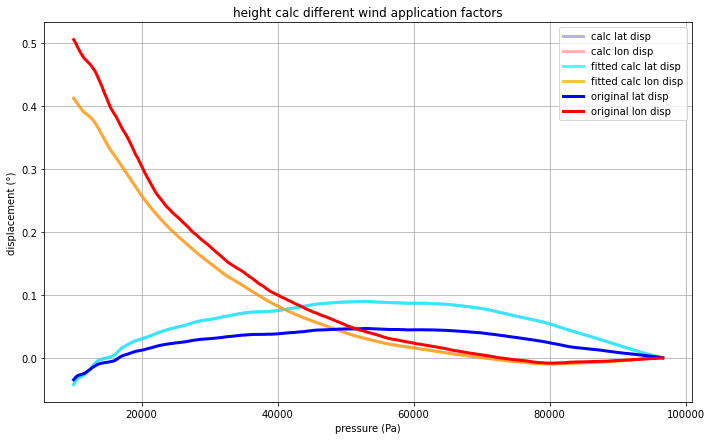

----------------
not a valid station
46.77 -100.76 20200531.0 230300.0


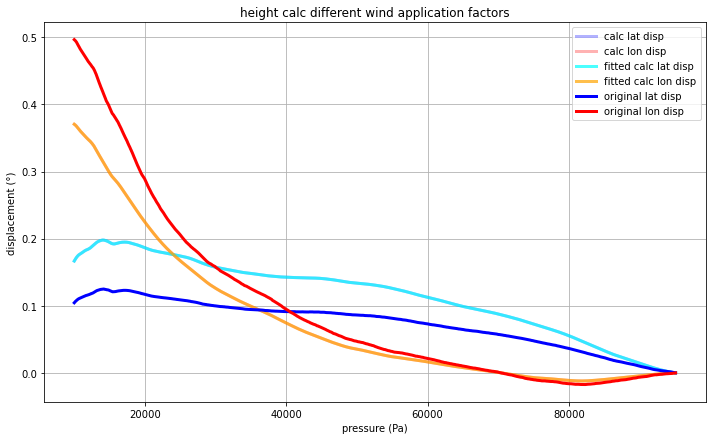

----------------
25.92 -97.42 20200531.0 230400.0


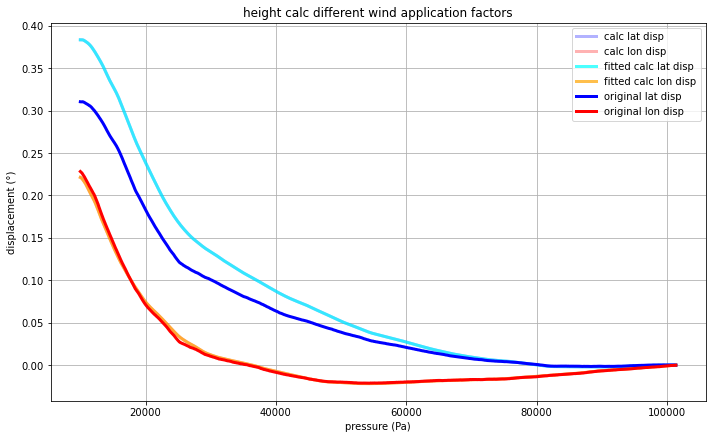

----------------
not a valid station
41.13 -100.7 20200531.0 230100.0


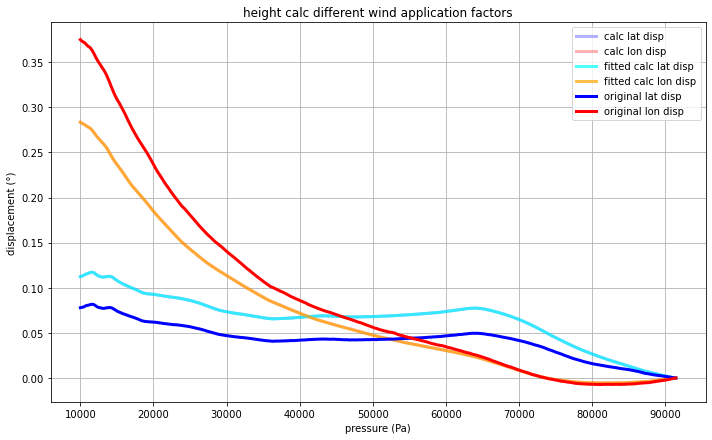

----------------
43.06 -108.48 20200531.0 230600.0


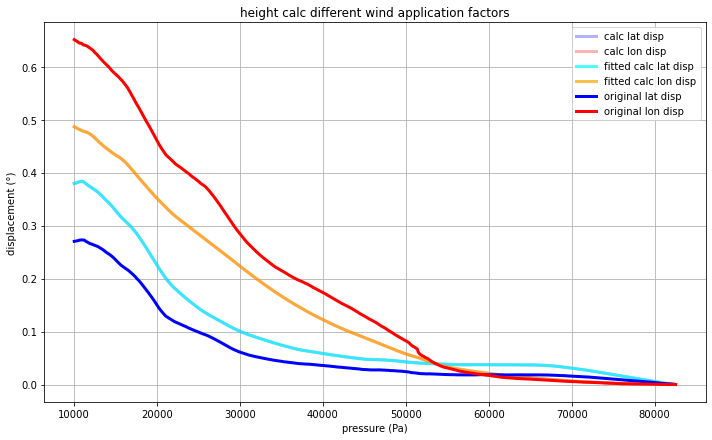

----------------
32.230000000000004 -110.96000000000001 20200531.0 230500.0


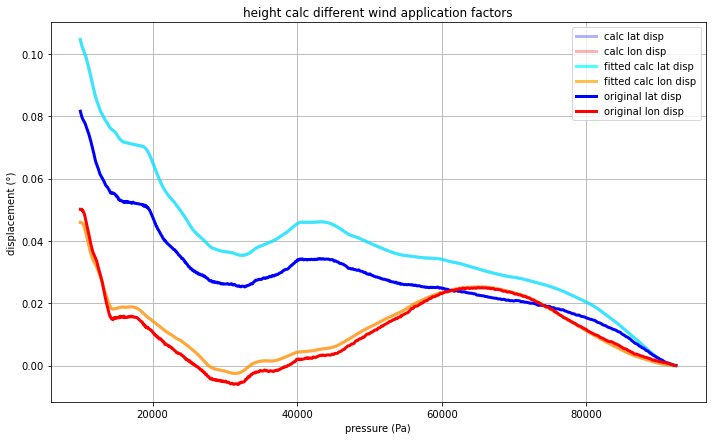

----------------
36.1 -79.94000000000001 20200531.0 230000.0


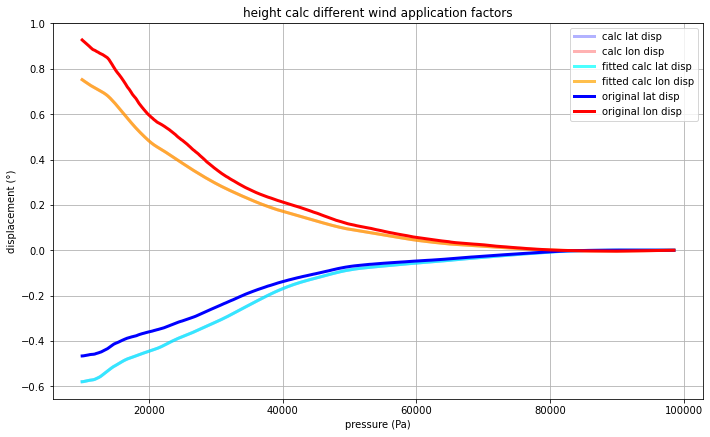

----------------
31.94 -102.19000000000001 20200531.0 230400.0


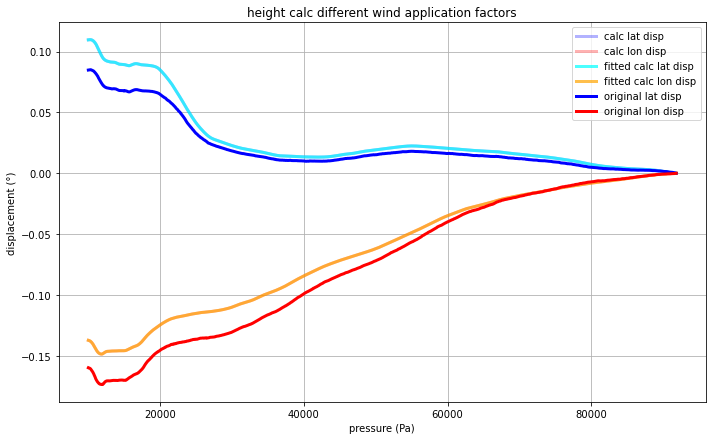

----------------
32.84 -97.30000000000001 20200531.0 230700.0


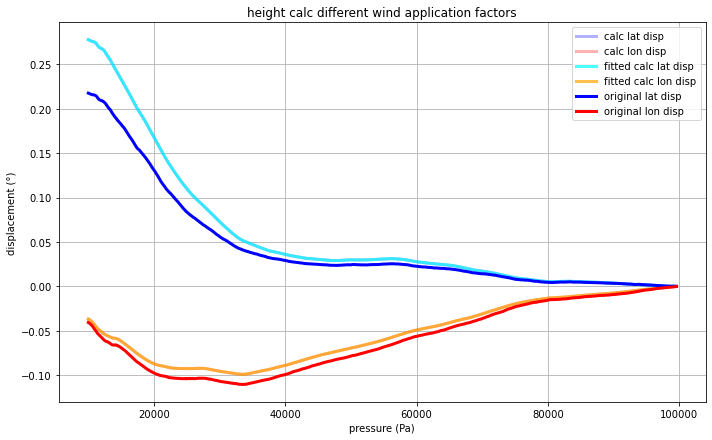

----------------
40.53 -80.22000000000001 20200531.0 230500.0


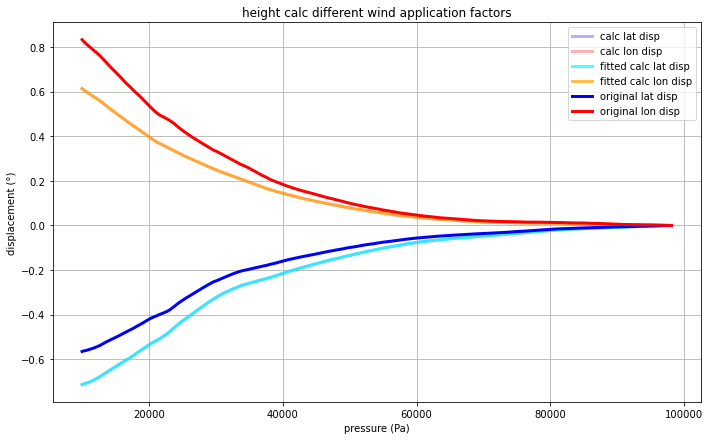

----------------
37.74 -122.22000000000001 20200531.0 230000.0


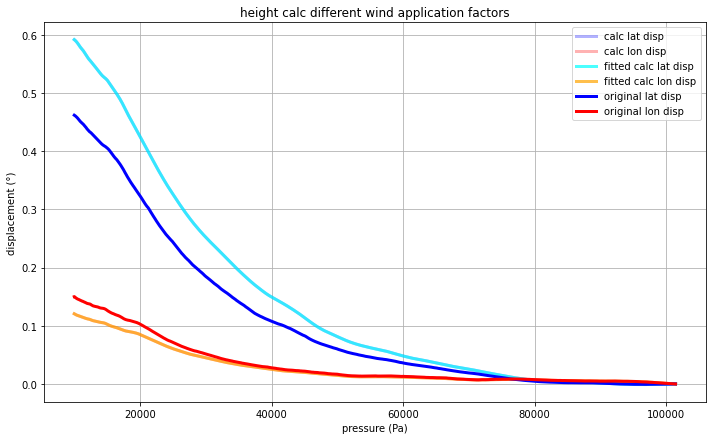

----------------
43.89 -70.26 20200531.0 230300.0


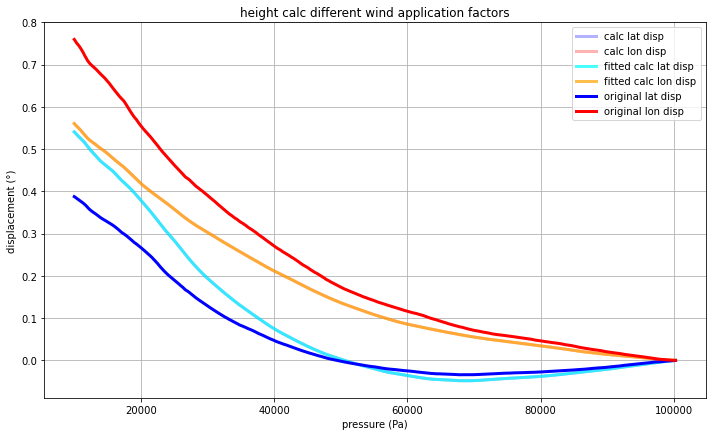

----------------
not a valid station
36.25 -86.56 20200531.0 230000.0


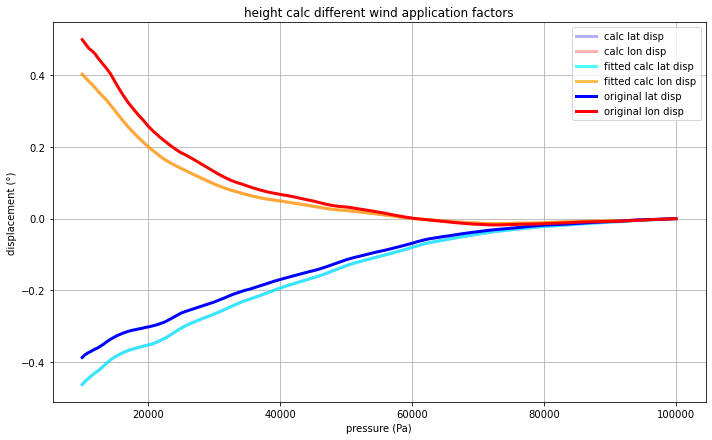

----------------
35.040000000000006 -106.62 20200531.0 231300.0


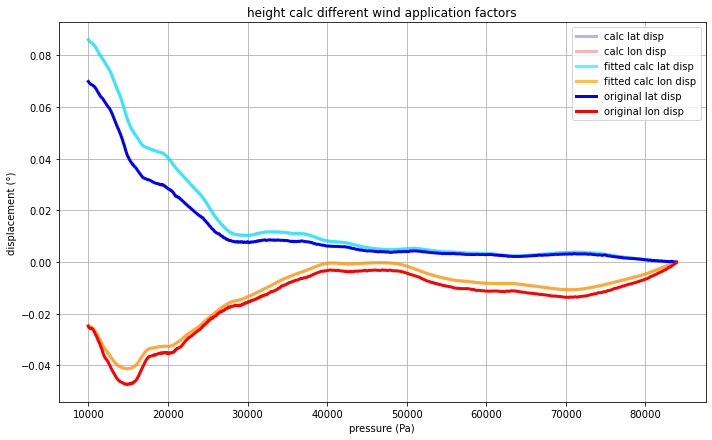

----------------
19.720000000000002 -155.06 20200531.0 230400.0


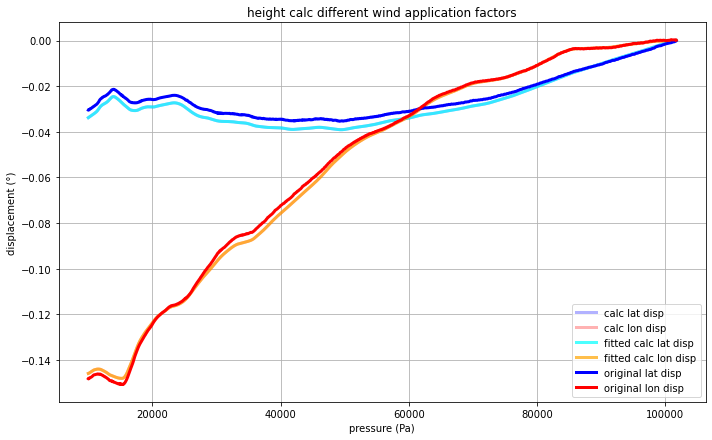

----------------
35.230000000000004 -111.82000000000001 20200531.0 230700.0


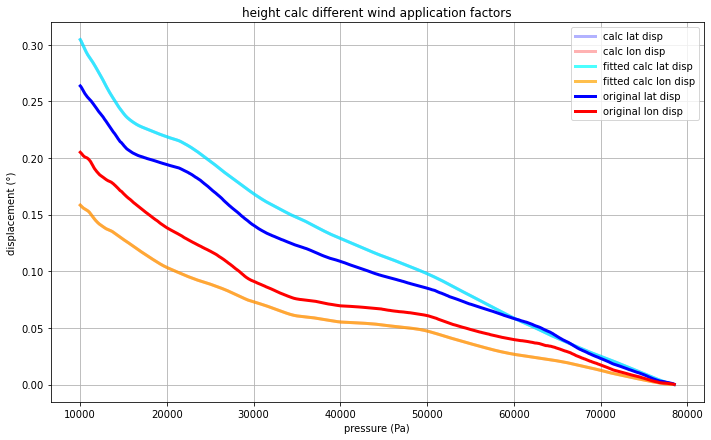

----------------
30.340000000000003 -89.83000000000001 20200531.0 230600.0


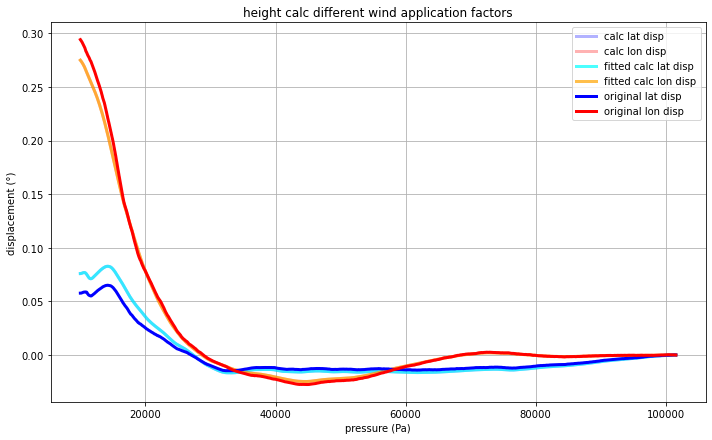

----------------
46.870000000000005 -68.01 20200531.0 230100.0


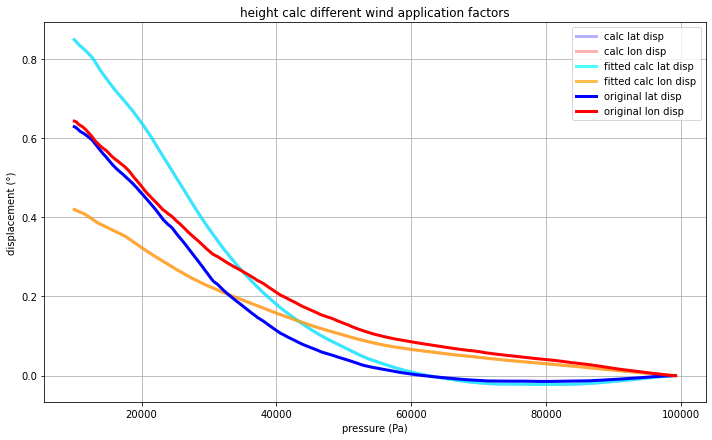

----------------
30.12 -93.22000000000001 20200531.0 230500.0


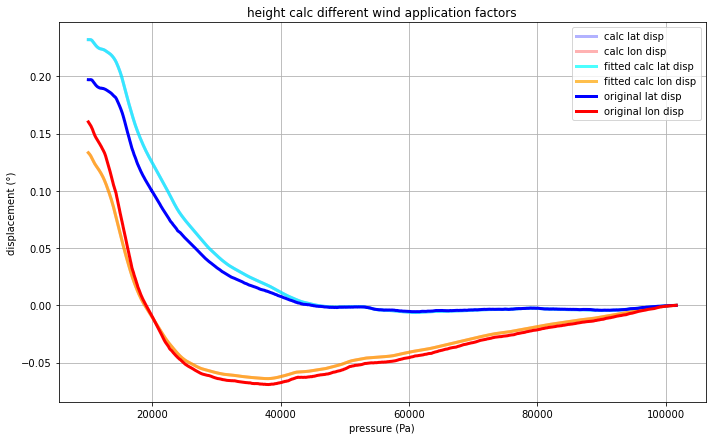

----------------
48.56 -93.4 20200531.0 230200.0


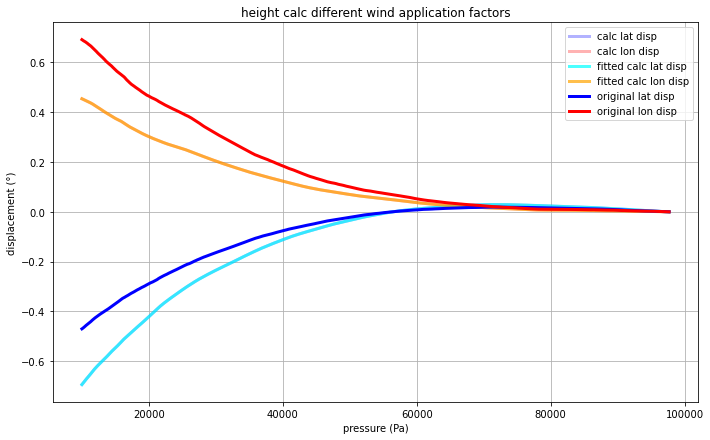

----------------
36.050000000000004 -115.19000000000001 20200531.0 231100.0


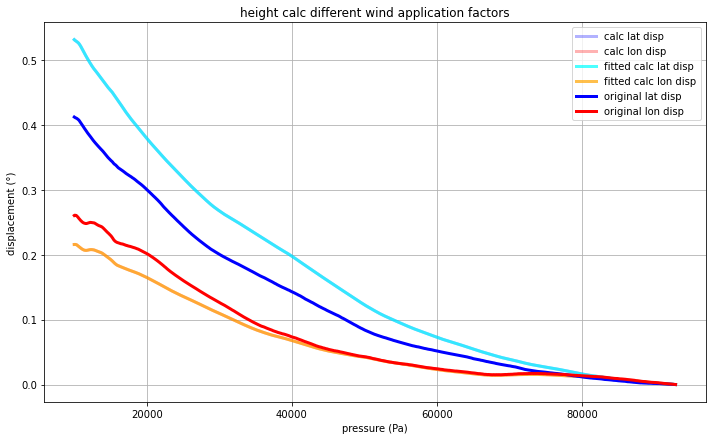

----------------
34.78 -76.88000000000001 20200531.0 230400.0


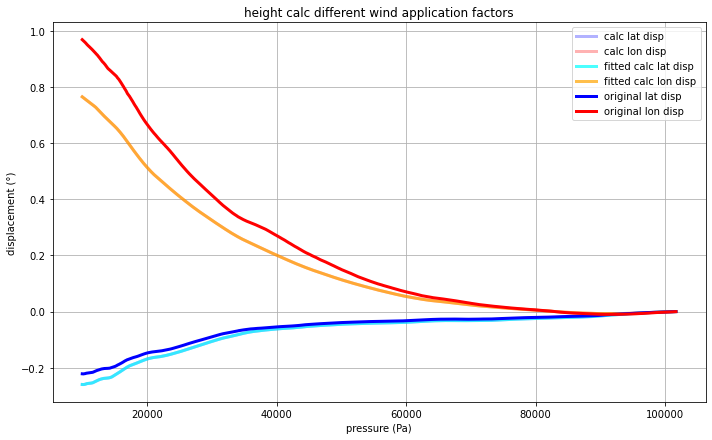

----------------
40.77 -111.95 20200531.0 230300.0


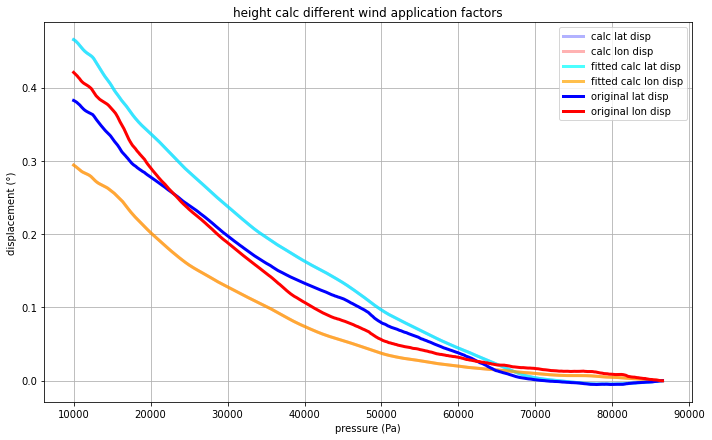

----------------
27.700000000000003 -82.4 20200531.0 230100.0


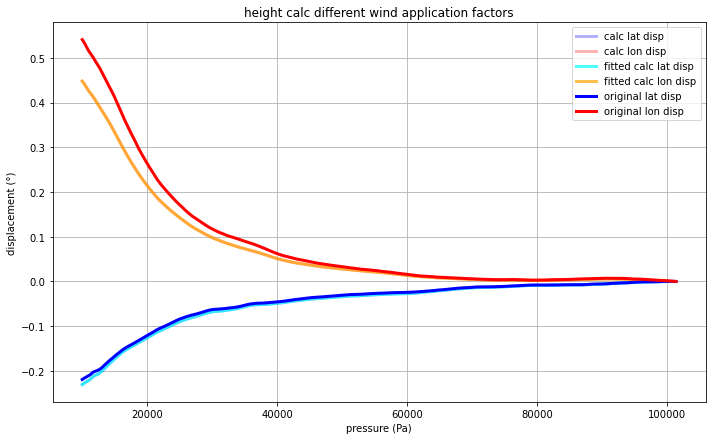

----------------
not a valid station
39.42 -83.82000000000001 20200531.0 230100.0


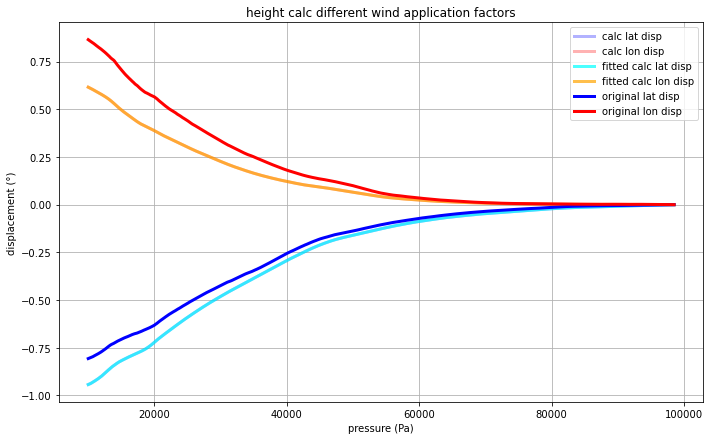

----------------
42.7 -83.47000000000001 20200531.0 230600.0


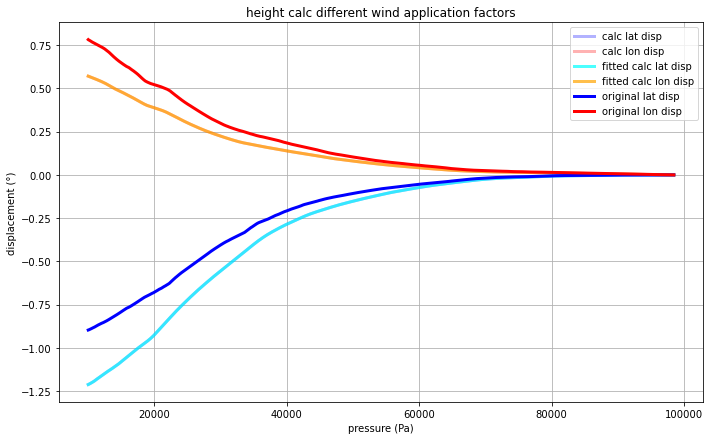

----------------
44.07 -103.21000000000001 20200531.0 230400.0


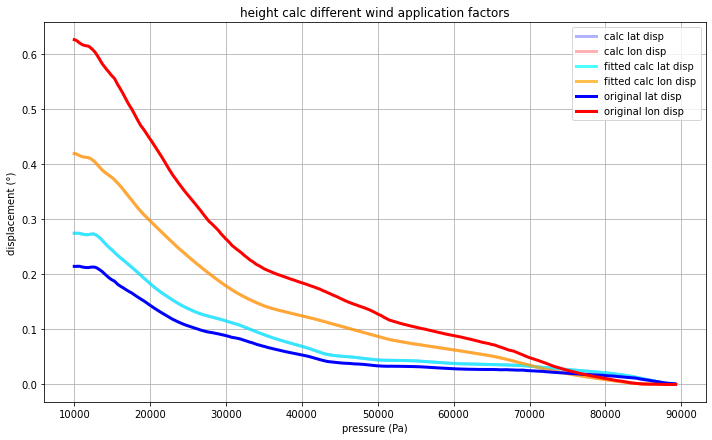

----------------
41.32 -96.37 20200531.0 230900.0


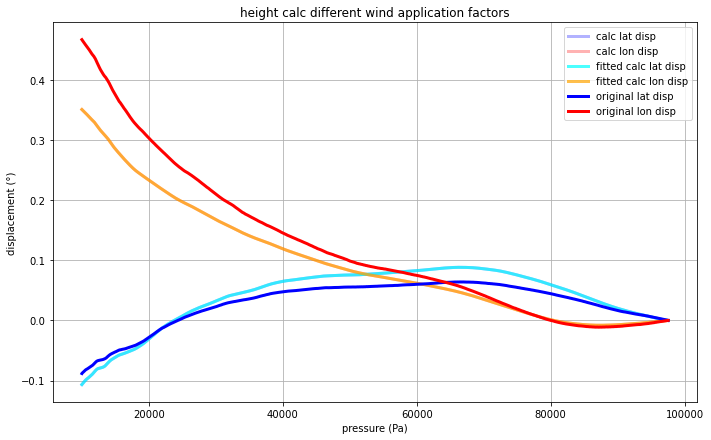

----------------
47.46 -111.39000000000001 20200531.0 230600.0


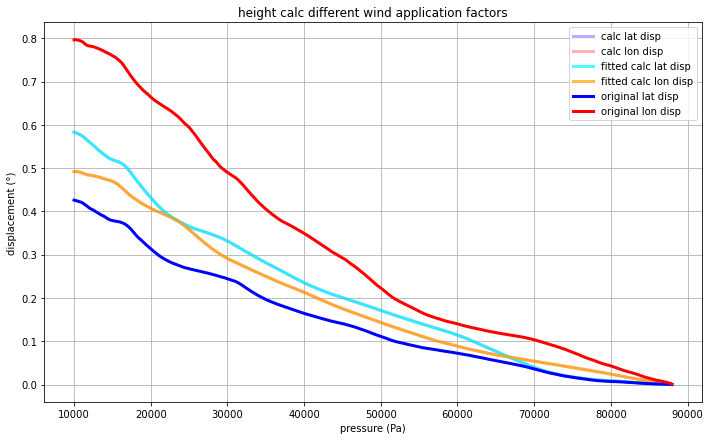

----------------
40.86000000000001 -115.74000000000001 20200531.0 230500.0


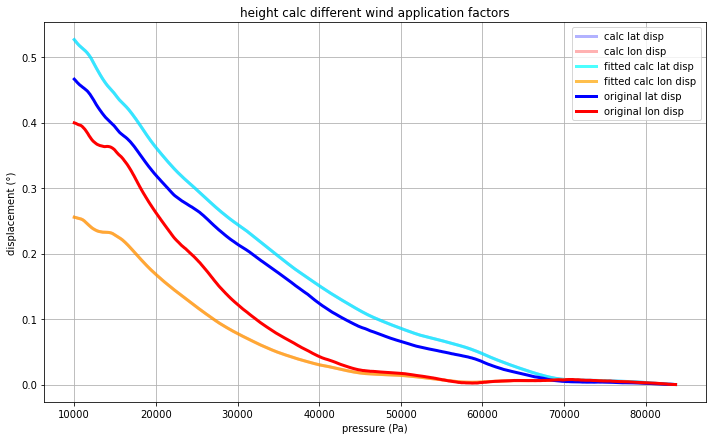

----------------
27.78 -97.51 20200531.0 230500.0


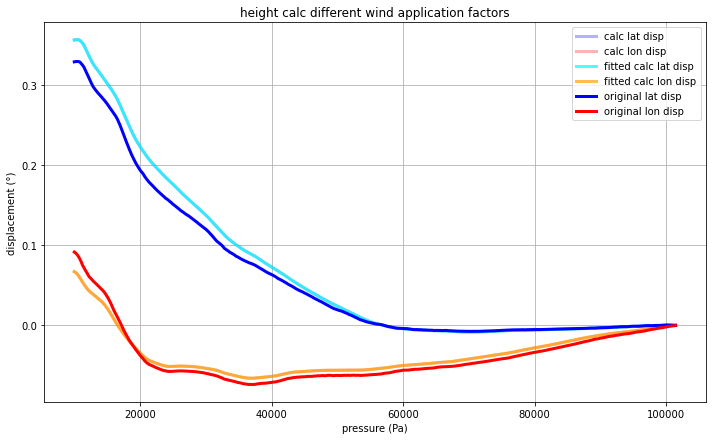

----------------
Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0009109584784610478
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0009495526544612952
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.0009109584784610478
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.0009495526544612952
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0009109584784610478
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0009495526544612952
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.0037589239215264077
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.00251822051120533
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.0037589239215264077
Longitude Displacement data set 2 - plev:  85000  RMSE:  0.00251822051120533
Latitude Displacement data set 1 - plev:  85000  RMS:  0.0037589239215264077
Longitude Displacement data set 1 - plev:  85000  RMS:  0.00251822051120533
Latitude Displacement data set 1 - plev:  70000  RM

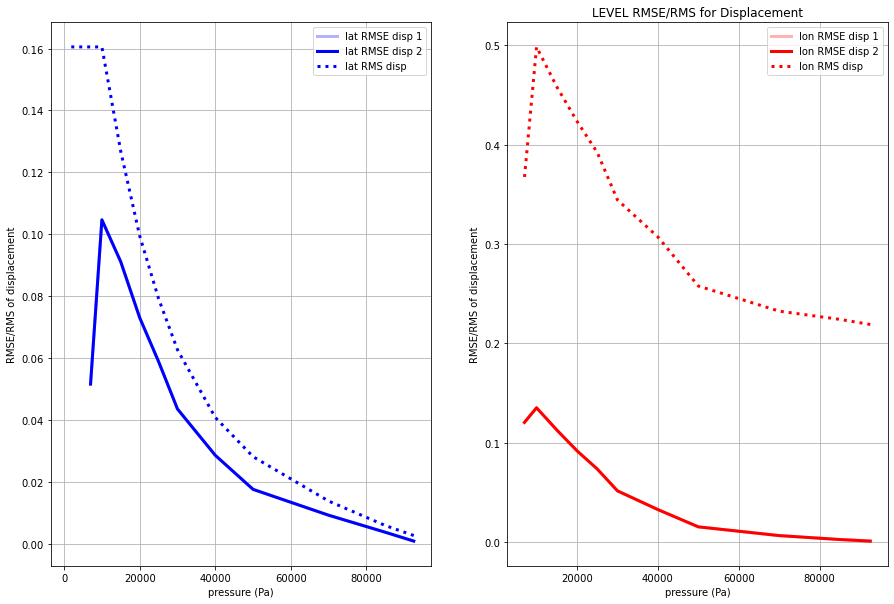

In [15]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0]) #'./out.bufr')# sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))
# # exit()